In [1]:
import sys
print(sys.version)

3.6.2 (default, Jul 17 2017, 16:44:45) 
[GCC 4.2.1 Compatible Apple LLVM 8.1.0 (clang-802.0.42)]


# Common Boggle Words

What words appear most often in a game of Boggle?

[Naively](https://english.stackexchange.com/questions/12747/is-it-spelt-na%C3%AFve-or-naive), we can count $16! \cdot 6^{16} \approx 5.9 \cdot 10^{25}$ different boards, not taking duplicate letters into account. This many boards is too a numerous; even if discovering words per board was as fast as $\mathcal{O}(\mathtt{pass})$, it would be too much.

In [2]:
import time
import numpy as np
from datetime import timedelta


def simple_loop(n):
    """Return how many seconds a simple loop takes."""
    start = time.time()
    for _ in range(n):
        pass
    return time.time() - start



x = np.arange(start=1, stop=1e6, step=1e4)
y = [simple_loop(int(n)) for n in x]

a, b = np.polyfit(x, y, deg=1)
seconds = a*1e25 - b
print(timedelta(seconds))

OverflowError: normalized days too large to fit in a C int

Great Scott!

In [3]:
from math import log10


C_MAX_INT = 2**31
log10(C_MAX_INT/365)

6.769637001126942

So we will recourse to sampling!

The game Boggle has a square board, with 16 slots for cubes. Each cube has letters on its 6 faces. Starting each game, the board is shuffled so that each cube is in a random slot, _and_ each cube has a random face showing.

Players compete to find most words showing on the resultant board. A player's score is based on the number of words that no other players found. Where longer words that no other players found are scored higher.

Words can be constructed from any non-repeating contiguous sequence of horizontal, vertical, or diagonal cubes. But sequences can't wrap around the board. Note too that the same letter may appear twice in a path, but not the same cube.


Lastly, the words must belong to an agreed upon dictionary, and be at least some minimum length.

## Simulating Boggle

There are 16 cubes one will find in a standard Boggle board:

In [7]:
cubes = [
    ('a', 'a', 'e', 'e', 'g', 'n'),
    ('a', 'b', 'b', 'j', 'o', 'o'), 
    ('a', 'c', 'h', 'o', 'p', 's'),
    ('a', 'f', 'f', 'k', 'p', 's'),
    ('a', 'o', 'o', 't', 't', 'w'),
    ('c', 'i', 'm', 'o', 't', 'u'),
    ('d', 'e', 'i', 'l', 'r', 'x'),
    ('d', 'e', 'l', 'r', 'v', 'y'),
    ('d', 'i', 's', 't', 't', 'y'),
    ('e', 'e', 'g', 'h', 'n', 'w'),
    ('e', 'e', 'i', 'n', 's', 'u'),
    ('e', 'h', 'r', 't', 'v', 'w'),
    ('e', 'i', 'o', 's', 's', 't'),
    ('e', 'l', 'r', 't', 't', 'y'),
    ('h', 'i', 'm', 'n', 'qu', 'u'),
    ('h', 'l', 'n', 'n', 'r', 'z'),
]

To simulate the process of shuffling a board, we uniformly choose a slots and faces.

In [8]:
from random import choice, shuffle
from itertools import islice


def rand_board():
    board = []
    shuffle(cubes)
    cube_order = iter(cubes)
    for i in range(4):
        row = islice(cube_order, 4)
        board.append([choice(cube) for cube in row])
    return board

In [9]:
rand_board()

[['w', 't', 'i', 'p'],
 ['n', 'x', 'e', 'n'],
 ['r', 'e', 's', 's'],
 ['t', 'b', 'n', 't']]

To find viable words on a board, we'll recursively traverse paths across the showing letters. Once a sequence goes out of bounds or repeats a cube, traversal in that direction will stop. 

Now, at each step in this process we could look up the sequence in a hash table. But, it may be the case that the current sequence is not a prefix of any word in the dictionary. So, it will be more efficient to store the dictionary in a trie. [Here](http://stackoverflow.com/a/11016430) is an inspiring elegant implementation.

In [10]:
def make_trie(words):
    root = {}
    for word in words:
        node = root
        for letter in word:
            node = node.setdefault(letter, {})
        node[None] = None    # signify that node is a word
    return root

In [11]:
import json


t = make_trie(['apply', 'apple', 'apt'])
print(json.dumps(t, indent=2))

{
  "a": {
    "p": {
      "p": {
        "l": {
          "y": {
            "null": null
          },
          "e": {
            "null": null
          }
        }
      },
      "t": {
        "null": null
      }
    }
  }
}


Now let's write that recursive function that generates unique words on a given board, of at least some length.

In [12]:
from itertools import product


def get_words(board, trie, min_len=3):
    """Yield possible words from a given board and trie."""
    offsets = [(-1, -1), (-1, 0), (-1, 1),
               (0,  -1),          (0,  1),
               (1,  -1), (1,  0), (1,  1)]
    
    def recur(i, j, path, seen, node):
        if (i, j) in seen:    # path can't cross itself
            return
        if not (0 <= i < 4) or not (0 <= j < 4):    # path can't wrap around board
            return
        letter = board[i][j]
        path += letter
        seen.add((i, j))
        if letter in node:    # path is a prefix
            if None in node[letter]:    # path is a word
                yield path
            for i_off, j_off in offsets:    # traverse neighbors even if path is word
                yield from recur(i + i_off, j + j_off, path, seen.copy(), node[letter])
    
    seen = set()
    for i, j in product(range(4), range(4)):
        for word in recur(i, j, '', set(), trie):
            if len(word) >= min_len and word not in seen:
                yield word
                seen.add(word)

Finding words necessitates a dictionary, and a _Scrabble_-esque dictionary seems fitting. Conveniently, the _Words With Friends_ game's dictionary is [publicly available](http://gaming.stackexchange.com/a/7163): the Enhanced North American Benchmark Lexicon.

In [13]:
with open('enable1.txt') as f:
    trie = make_trie(word.strip() for word in f)

## Estimating Word Probabilities

To estimate word frequencies, we'll gather relative frequencies from random boards. But how many boards to sample from?

We can view the appearance of a specific word as a Bernoulli random variable with some unknown probability. We'd like to sample enough boards so that the resultant $k$ most common words is are in fact the most common, and in order.

In the land of probability bounds, where Markov and Chebyshev wander wide, one called Hoeffding's inequality is particularly powerful when it comes to Bernoulli variables. It can tell us how tight an $\epsilon$-sized confidence interval should be with $n$ samples.

Specifically, let $X_1, \ldots, X_n \sim \mathrm{Bernoulli}(p)$. Then, for any $\epsilon > 0$,

$$P(\left| \overline{X_n} - p \right| > \epsilon) \le 2 e^{-2n\epsilon^2}$$

So, to be $\alpha$ confident that some variable is within error $\epsilon$ of it's true value, we'll need

$$n \ge \frac{1}{2\epsilon^2}\log{\frac{2}{\alpha}}$$

samples.

This applies to any Bernoullie variable, and each random Boggle board gives a Bernoulli value to every word (it appears or it doesn't). So, we can just sample a bunch of boards, which will probably produce a tight enough bound.

However, we'll have to be very diligent about choosing our confidence $\alpha$, and tightness $\epsilon$. We can't guarantee that the top $k$ words are in fact the top $k$, and in order, but it does ossify those top probabilities with a diligently chosen $\epsilon$.

Experimenting with 1000 boards showed that top 10 words' probabilities overlap, suggesting that we need $\epsilon < 0.001$ to be, say, $\alpha = 0.1$ confident that the ordering is correct. Unfortunately, this would lead to $n \ge 1.5 \times 10^6$ boards, which is too many hours of computation. Instead we'll shoot for just having the same set of top words, rather than correct ranking. The difference in probability between the empirical most common word and the 20th (we choose $k$ arbitrarily) was about 0.01, yielding $n \ge 14979$ boards, which is more manageable.

In [20]:
%%time
from collections import Counter
from tabulate import tabulate
import multiprocessing as mp

NBOARDS = 14979


def update_counts(_):
    board = rand_board()
    return Counter(get_words(board, trie, min_len=4))


counts = Counter()
nprocs = mp.cpu_count()
with mp.Pool(processes=nprocs) as pool:
    it = pool.imap_unordered(update_counts, range(NBOARDS),
                             chunksize=500)
    for sampled_counts in it:
        counts += sampled_counts


table = [(i, word, count/NBOARDS) for i, (word, count)
         in enumerate(counts.most_common(20), start=1)]
print(tabulate(table, headers=['Rank', 'Word', 'Frequency'], floatfmt='.4f'))

  Rank  Word      Frequency
------  ------  -----------
     1  teen         0.0642
     2  tees         0.0639
     3  toes         0.0575
     4  note         0.0575
     5  teat         0.0573
     6  tent         0.0565
     7  tone         0.0565
     8  toea         0.0558
     9  neat         0.0525
    10  test         0.0524
    11  nets         0.0517
    12  sent         0.0511
    13  nest         0.0510
    14  teas         0.0508
    15  thee         0.0505
    16  seta         0.0502
    17  ates         0.0502
    18  tens         0.0501
    19  ante         0.0501
    20  etna         0.0501
CPU times: user 52.8 s, sys: 562 ms, total: 53.4 s
Wall time: 1min 13s


## Common and Ordinary Word Ranking

The most common list is interesting, but some of the words are so ordinary that other players will probably know them and also find them. To improve one's chances of winning Boggle, it would be nice to have a ranking that takes into account both a word's probability of occurence, *and ordinariness*.

This is reminiscent [tf-idf weighting](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html)! Our current list gives us the *term frequency*, so all that remains is to find each term's *inverse document frequency*. Here, we assume that usage corresponds to how likely it is for a word to be known.

We'll use word usage counts from [American National Corpus](http://www.anc.org/data/anc-second-release/frequency-data/). However, some of the words from Boggle might have various endings (e.g. "apple", "apples"), and those should add in frequency for "ordinariness." So we'll stem the words for lookup.

In [21]:
from nltk.stem import SnowballStemmer
from collections import defaultdict


snow = SnowballStemmer('english')
freqs = defaultdict(int)
min_freq = 1    # smallest frequency found, for use with Boggle words not in list

with open('ANC-token-count.txt', encoding='ISO-8859-1') as f:    # there's weird characters
    for word, *_, freq in map(str.split, f):
        if word == 'Total':    # there was a total count of words at the end
            continue
        word, freq = snow.stem(word), float(freq)
        freqs[word] += freq
        min_freq = freqs[word]

Now, we just need to calculate the scores of the words output a new sorted list.

In [22]:
from math import log


tfs, idfs = [], []
for word, count in counts.items():
    word = snow.stem(word)
    tfs.append(1 + count)
    idfs.append(log(1 + 1/freqs.get(word, min_freq)))

scores = sorted([(tf*idf, word) for tf, idf, word in zip(tfs, idfs, counts.keys())], reverse=True)
table = [(i, word, score) for i, (score, word) in enumerate(scores[:20], start=1)]
print(tabulate(table, headers=['Rank', 'Word', 'Score']))

  Rank  Word      Score
------  ------  -------
     1  toea    14157
     2  seta    12736.3
     3  nett    12668.6
     4  teat    12641.7
     5  stet    12228.8
     6  tret    11721.4
     7  rete    11719.2
     8  sett    11653.8
     9  tees    11617.2
    10  etna    11493.7
    11  teel    11078.7
    12  hest    10994.1
    13  teth    10981.5
    14  haet    10841.9
    15  nite    10547.4
    16  hent    10419
    17  eath    10419
    18  tine    10407.1
    19  leet    10359.1
    20  sate    10339.6


# Epilogue

After completing this task, several sub-topics came to mind. We address some of those here. Unlike in previous sections, we will be lax proving the correct number of boards.

## Number of Possible Words Distribution

It would be interesting to see the minimum, maximum, mean, etc. of the number of words found over all boards. For the sake of brevity, rather than fitting the distribution and devising estimators, we'll just plot a simple histogram. And I choose an arbitrarily large number of boards to sample from.

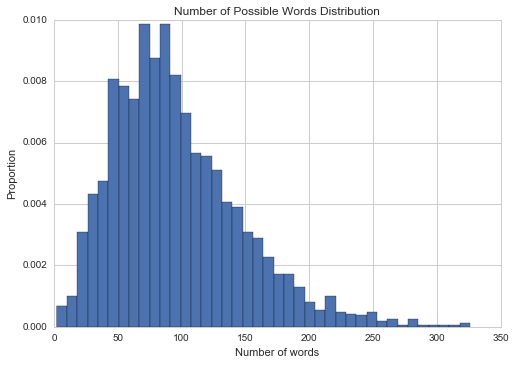

In [23]:
import matplotlib.pyplot as plt
import seaborn


%matplotlib inline
seaborn.set_context('notebook')
seaborn.set_style('whitegrid')

num_words = []
for _ in range(2000):
    num_words.append(len(list(get_words(rand_board(), trie))))
    
plt.hist(num_words, bins=40, normed=True)
plt.title('Number of Possible Words Distribution')
plt.xlabel('Number of words')
plt.ylabel('Proportion')
plt.show()

## Best Proportion of Vowels

A friend gave the comment that the "best" Boggle boards are comprised of 40% vowels. Best, here, was intended to mean highest number of word solutions. Now to experimentally prove this claim.

In [24]:
from itertools import chain
from collections import defaultdict


NBOARDS = 1000
data = defaultdict(int)    # store how many words found per vowel, summed over boards
vowels = set('aeiou')    # for simplicity we assume that these are the only vowels

for _ in range(NBOARDS):
    num_vowels = 0
    board = rand_board()
    for letter in chain(*board):
        if letter in vowels:
            num_vowels += 1
    num_words = len(list(get_words(board, trie, min_len=4)))
    data[num_vowels] += num_words

Now to plot the mean number of found words per number of vowels:

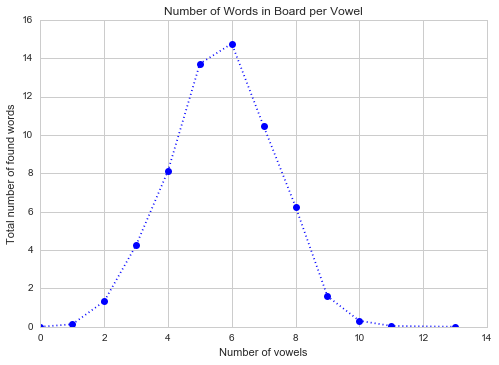

In [28]:
x, y = zip(*sorted(data.items()))

plt.plot(x, [t/NBOARDS for t in y], 'bo:')
plt.title(r'Number of Words in Board per Vowel')
plt.xlabel('Number of vowels')
plt.ylabel('Total number of found words')
plt.show()

In [26]:
6/16

0.375

Would you look at that, 40% was pretty spot on for an off the cuff comment.

## Super Big Boggle

In [27]:
big_cubes = [
    ('s', 's', 's', 'u', 'n', 'e'),
    ('qu', 'j', 'k', 'z', 'w', 'x'),
    ('a', 'a', 'a', 's', 'f', 'r'),
    ('h', 'o', 'r', 'd', 'l', 'n'),
    ('g', 'o', 'r', 'w', 'r', 'v'),
    ('f', 's', 'i', 'r', 'a', 'a'),
    ('an', 'in', 'er', 'he', 'th', 'qu'),
    ('a', 'e', 'a', 'e', 'e', 'e'),
    ('l', 'i', 'e', 'a', 'n', 'm'),
    ('g', 'f', 'n', 'u', 'y', 'c'),
    ('a', 'e', 'm', 'e', 'e', 'e'),
    ('h', 'd', 't', 'n', 'o', 'd'),
    ('h', 's', 'e', 'r', 'i', 'l'),
    ('n', 'u', 'e', 'o', 'i', 'a'),
    ('o', 'n', 'd', 'w', 'h', 'h'),
    ('a', 'o', 'i', 'e', 'b', 'd'),
    ('l', 'h', 'h', 'r', 'd', 'o'),
    ('g', 'n', 'a', 'm', 'n', 'e'),
    ('s', 't', 'r', 'h', 'p', 'o'),
    ('n', 'd', 'e', 'a', 'n', 'n'),
    ('o', 'o', 'a', 'e', 'a', 'e'),
    ('t', 'm', 't', 'e', 'o', 't'),
    ('t', 'i', 's', 'r', 'v', 'h'),
    ('a', 'e', 'm', 'g', 'u', 'e'),
    ('t', 'i', 'l', 's', 'p', 'e'),
    ('n', 'o', 'w', 'o', 'u', 't'),
    ('y', 'r', 'y', 's', 'i', 'p'),
    ('e', 's', 'p', 't', 'i', 'c'),
    ('c', 't', 'n', 's', 'e', 'c'),
    ('y', 'r', 'f', 's', 'i', 'a'),
    ('l', 'c', 'd', 'd', 'n', 'n'),
    ('t', 'i', 't', 'c', 't', 'e', 'i'),
    ('e', 't', 'i', 'l', 'i', 's'),
    ('j', 'b', 'b', 'z', 'x', 'k'),
    ('o', 'o', 'o', 't', 'u', 't'),
    ('o', 'i', None, None, 'e', None)
]